# Modelamiento ETL de datos
## Importar bibliotecas

In [1]:
# Librerías para Manipulación y Análisis de Datos
import pandas as pd
import numpy as np

# Librerías para Procesamiento de Texto
import re
from unidecode import unidecode

# Librerías para Trabajo con Fechas
import datetime

# Librerías para Visualización de Datos
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías para Operaciones en el Sistema y Scraping
import os
import requests
import gzip
import shutil
from tqdm import tqdm
from datetime import timedelta, date
import math
from bs4 import BeautifulSoup
from pathlib import Path

## Importación de Datos

In [2]:
homicidios = pd.read_excel('../datasets/raw/homicidios.xlsx',sheet_name = 'HECHOS', engine='openpyxl')
victima_h = pd.read_excel('../datasets/raw/homicidios.xlsx',sheet_name = 'VICTIMAS',  engine='openpyxl')
comunas_h = pd.read_excel('../datasets/raw/comunas.xlsx' , sheet_name = 'comunas',  engine='openpyxl')

censo_r = pd.read_csv('../datasets/raw/informacion-censal-por-radio-2010.csv')

homicidios.name = 'homicidios'
victima_h.name = 'victima_h'
comunas_h.name = 'comunas_h'
censo_r.name = 'censo_r'

In [3]:
pd.set_option('display.max_columns', None)
dataframes = [homicidios, victima_h, comunas_h, censo_r]

In [4]:
for df in dataframes:
    print(f"Dataframe {df.name}:\nRegistros {df.shape[0]} y Columnas {df.shape[1]}\n")

Dataframe homicidios:
Registros 696 y Columnas 21

Dataframe victima_h:
Registros 717 y Columnas 10

Dataframe comunas_h:
Registros 15 y Columnas 6

Dataframe censo_r:
Registros 3554 y Columnas 15



## PreProcesamiento de Datos

In [5]:
# Función para limpiar y formatear los nombres de las columnas
def limpiar_nombre(nombre):
    # Eliminar caracteres especiales y espacios
    nombre = re.sub(r'\W+', '_', nombre)
    # Eliminar acentos
    nombre = unidecode(nombre)
    # Convertir a minúsculas
    nombre = nombre.lower()
    return nombre

def limpiar_nombres_columnas(df):
    df.columns = [limpiar_nombre(col) for col in df.columns]

# Aplicar la función limpiar_nombres_columnas a cada DataFrame
for df in dataframes:
    limpiar_nombres_columnas(df)

# Imprimir los nombres de las columnas limpias para cada DataFrame
for df in dataframes:
    print(f"Columnas de {df.name}:")
    print(df.columns)
    print()

Columnas de homicidios:
Index(['id', 'n_victimas', 'fecha', 'aaaa', 'mm', 'dd', 'hora', 'hh',
       'lugar_del_hecho', 'tipo_de_calle', 'calle', 'altura', 'cruce',
       'direccion_normalizada', 'comuna', 'xy_caba_', 'pos_x', 'pos_y',
       'participantes', 'victima', 'acusado'],
      dtype='object')

Columnas de victima_h:
Index(['id_hecho', 'fecha', 'aaaa', 'mm', 'dd', 'rol', 'victima', 'sexo',
       'edad', 'fecha_fallecimiento'],
      dtype='object')

Columnas de comunas_h:
Index(['id', 'objeto', 'comunas', 'barrios', 'perimetro', 'area'], dtype='object')

Columnas de censo_r:
Index(['wkt', 'id', 'co_frac_ra', 'comuna', 'fraccion', 'radio', 'total_pob',
       't_varon', 't_mujer', 't_vivienda', 'v_particul', 'v_colectiv',
       't_hogar', 'h_con_nbi', 'h_sin_nbi'],
      dtype='object')



In [6]:
def reemplazar_nulos_y_raros(dataframes, valores_raros):
    dataframes_limpios = []

    for df in dataframes:
        # Reemplazar los valores raros con NaN
        df = df.replace(valores_raros, pd.NaT)

        # Reemplazar los valores nulos con NaN
        df = df.replace('', pd.NaT)

        dataframes_limpios.append(df)

    return dataframes_limpios

dataframes = [homicidios, victima_h, comunas_h, censo_r]
# Definir qué valores consideras "raros"
valores_raros = ['SD', 'No especificado', 'sd' , '']
# Ejemplo de uso
# Supongamos que tienes una lista de DataFrames llamada 'dataframes' y 'valores_raros' es la lista de valores raros
dataframes_limpios = reemplazar_nulos_y_raros(dataframes, valores_raros)

# Puedes asignar cada DataFrame tratado a una variable separada
homicidios_l, victima_h_l, comunas_h_l, censo_r_l = dataframes_limpios.copy()


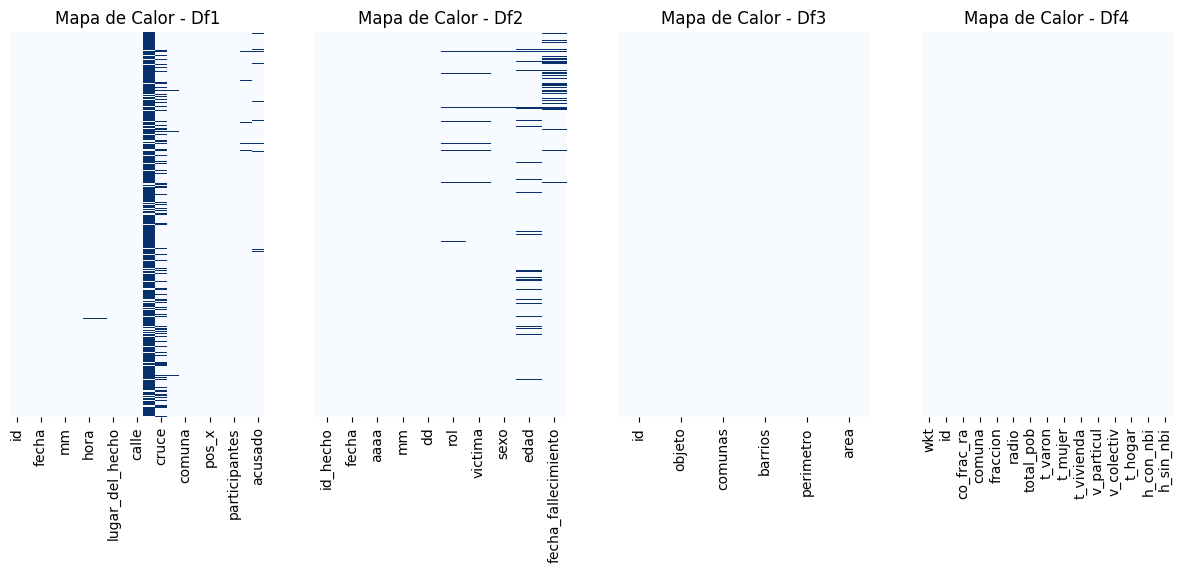

In [7]:
n_dataframes = len(dataframes_limpios)

# Configurar la disposición de los subgráficos
fig, axs = plt.subplots(1, n_dataframes, figsize=(15, 5))  # Ajusta el tamaño según tus necesidades

# Iterar sobre los índices de los DataFrames y dibujar el mapa de calor en cada subgráfico
for i in range(n_dataframes):
    sns.heatmap(dataframes_limpios[i].isna(), yticklabels=False, cbar=False, cmap="Blues", ax=axs[i])
    axs[i].set_title(f'Mapa de Calor - Df{i+1}')  # Utiliza el índice para el título

plt.show()

**Se asume la politica de eliminar, según reporte EDA:**
-  Campos gravedad de Df victima_l con 98% Faltantes, 
-  Campos gravedad de Df lesiones con 97% Faltantes y
-  Campos altura de Df homicidios con 81% Faltantes.

In [8]:
def procesar_dataframe(df):
    # Convertir la columna de fecha a datetime
    df['fecha'] = pd.to_datetime(df['fecha'])

    # Crear nuevas columnas para año, mes y día
    df['anio'] = df['fecha'].dt.year
    df['mes'] = df['fecha'].dt.month
    df['dia'] = df['fecha'].dt.day

    # Llenar los valores nulos en 'hora' con '00:00:00'
    df['hora'] = df['hora'].fillna('00:00:00')


    # Convertir 'hora' a formato datetime
    df['hora'] = pd.to_datetime(df['hora'], format='%H:%M:%S')

    # Crear una nueva columna para fecha y hora combinadas
    df['fecha_hora'] = pd.to_datetime(dict(
        year=df['anio'],
        month=df['mes'],
        day=df['dia'],
        hour=df['hora'].dt.hour,
        minute=df['hora'].dt.minute
    ))

    # Eliminar columnas innecesarias
    columns_to_drop = ['fecha', 'aaaa', 'mm', 'dd', 'hh','hora','altura']
    df = df.drop(columns=columns_to_drop)

    # Crear columnas formateadas para fecha y hora
    df['fecha_formato'] = df['fecha_hora'].dt.strftime('%Y-%m-%d')
    df['hora_formato'] = df['fecha_hora'].dt.strftime('%H:%M')
    df['hora_i'] = df['fecha_hora'].dt.strftime('%H')
    df['hora_i'] = df['hora_i'].astype('int')

    return df

# Ejemplo de uso:
# Supongamos que tu DataFrame se llama 'df'
homicidios_l = procesar_dataframe(homicidios_l.copy())


In [9]:
def procesar_homicidios_l(df):
    
    # Seleccionar todas las columnas de tipo objeto
    columnas_objeto = df.select_dtypes(include=['object']).columns
    
    # Reemplazar los valores NaN con "SRE" en las columnas seleccionadas
    df[columnas_objeto] = df[columnas_objeto].fillna("SNR")
    
    return df

# Ejemplo de uso:
# Supongamos que tu DataFrame se llama 'victima_h_l'
homicidios_l = procesar_homicidios_l(homicidios_l.copy())

In [10]:
def procesar_homicidios_l(df):
    valid_positions = ~(df['pos_x'].str.contains('[^0-9.,-]') | df['pos_y'].str.contains('[^0-9.,-]') | (df['pos_x'] == '.') | (df['pos_y'] == '.'))

    # Establecer posiciones no válidas en NaN
    df.loc[~valid_positions, ['pos_x', 'pos_y']] = np.nan

    # Convertir las cadenas a tipo numérico (float)
    df['pos_x'] = df['pos_x'].str.replace(',', '.').astype(float)
    df['pos_y'] = df['pos_y'].str.replace(',', '.').astype(float)
    # Supongamos que tu DataFrame se llama df
    df.rename(columns={'pos_x': 'longitud', 'pos_y': 'latitud'}, inplace=True)

    #df['longitud'].fillna(0, inplace = True)
    #df['latitud'].fillna(0, inplace = True)   
    return df
def extraer_coordenadas(texto):
    # Utilizamos una expresión regular para extraer las coordenadas
    coordenadas = re.findall(r'\d+\.\d+', texto)
    if len(coordenadas) == 2:
        return float(coordenadas[0]), float(coordenadas[1])
    else:
        return None, None

homicidios_lm = procesar_homicidios_l(homicidios_l)
# Aplicar la función a la columna 'XY (CABA)'
homicidios_lm['coordenada_x'], homicidios_lm['coordenada_y'] = zip(*homicidios_lm['xy_caba_'].map(extraer_coordenadas))

# Eliminar columnas innecesarias
columns_to_drop = ['xy_caba_', 'calle','cruce','participantes', 'victima']
homicidios_lm = homicidios_lm.drop(columns=columns_to_drop)



In [11]:
def procesar_victima_h_l(df):
    # Llenar los valores nulos en 'fecha_fallecimiento' con 'fecha' + 7 días
    df['fecha_fallecimiento'] = df['fecha_fallecimiento'].combine_first(df['fecha'] + pd.DateOffset(days=7))
    
    df['edad'] = pd.to_numeric(df['edad'], errors='coerce')
    
    # Llenar los valores nulos en 'edad' con -1
    df['edad'] = df['edad'].fillna(-1)
    
    # Filtrar valores no negativos en 'edad' y luego convertir a entero
    df['edad'] = np.where((df['edad'] >= 0), df['edad'].astype(int), -1)

  
    # Seleccionar todas las columnas de tipo objeto
    columnas_objeto = df.select_dtypes(include=['object']).columns
    
    # Reemplazar los valores NaN con "SRE" en las columnas seleccionadas
    df[columnas_objeto] = df[columnas_objeto].fillna("SNR")
    
    # Eliminar columnas innecesarias
    columns_to_drop = ['fecha', 'aaaa', 'mm', 'dd']
    df2 = df.drop(columns=columns_to_drop)
    
    # Llenar los valores nulos en 'hora' con '00:00:00'
    df2['fecha_fallecimiento'] = df2['fecha_fallecimiento'].fillna('2018-09-21 00:00:00')
    df2['fecha_fallecimiento'] = pd.to_datetime(df2['fecha_fallecimiento'])

    return df2

# Ejemplo de uso:
# Supongamos que tu DataFrame se llama 'victima_h_l'
victima_h_lm = procesar_victima_h_l(victima_h_l.copy())


In [12]:
victima_h_lm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id_hecho             717 non-null    object        
 1   rol                  717 non-null    object        
 2   victima              717 non-null    object        
 3   sexo                 717 non-null    object        
 4   edad                 717 non-null    int32         
 5   fecha_fallecimiento  717 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int32(1), object(4)
memory usage: 30.9+ KB


In [13]:
victima_h_lm.shape

(717, 6)

In [14]:
homicidios_lm.shape

(696, 18)

In [15]:
censo_r_l.shape

(3554, 15)

## Expotar Datos ETL

In [25]:
homicidios_lm.to_csv('../datasets/processed/homicidios_lm.csv')

In [26]:
victima_h_lm.to_csv('../datasets/processed/victima_h_lm.csv')

In [27]:
comunas_h_l.to_csv('../datasets/processed/comunas_h_l.csv')

In [28]:
censo_r_l.to_csv('../datasets/processed/censo_r_l.csv')